In [1]:
import itertools
import numpy as np
from tqdm import tqdm
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, tdim=100):
    """
    Truncate a colormap by taking a segment between minval and maxval.

    Parameters:
        cmap : matplotlib colormap
            Original colormap to be truncated.
        minval : float, default 0.0
            Minimum value to start truncating.
        maxval : float, default 1.0
            Maximum value for truncation.
        tdim : int, default 100
            Number of discrete colors to generate.

    Returns:
        new_cmap : matplotlib colormap
            The truncated colormap.
    """
    truncated_name = f"trunc({cmap.name},{minval:.2f},{maxval:.2f})"
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        truncated_name,
        cmap(np.linspace(minval, maxval, tdim))
    )
    return new_cmap


def calc_norm_limits(low, high):
    """
    Calculate normalized limits for color mapping.

    The function scales the input values so that the maximum absolute value is normalized
    to 1, then adjusts the range to [0, 1].

    Parameters:
        low : float
            Lower bound value.
        high : float
            Upper bound value.

    Returns:
        norm_low, norm_high : tuple of floats
            Normalized lower and upper limits.
    """
    # Ensure that low is no more than 0 and high is no less than 0
    low = min(low, 0)
    high = max(high, 0)

    # Normalize by the maximum absolute value
    scale_factor = max(abs(np.array([low, high])))
    norm_low = low / scale_factor
    norm_high = high / scale_factor

    # Shift and scale to [0, 1]
    norm_low = norm_low / 2 + 0.5
    norm_high = norm_high / 2 + 0.5

    return norm_low, norm_high


def pltimshow(imshowdata, vmin=None, vmax=None, fig=None, ax=None, **kwargs):
    """
    Display an image using imshow with a truncated colormap and an attached colorbar.

    Parameters:
        imshowdata : array-like
            Image data to be displayed.
        vmin : float, optional
            Minimum data value for colormap scaling.
        vmax : float, optional
            Maximum data value for colormap scaling.
        fig : matplotlib Figure, optional
            Figure object; required if ax is provided.
        ax : matplotlib Axes, optional
            Axes object on which to draw the image.
        **kwargs : dict
            Additional keyword arguments passed to plt.imshow() or ax.imshow().
    """
    # Mask invalid values in the image data
    imshowdata = np.ma.masked_invalid(imshowdata)

    # Set color scaling if not provided
    if vmax is None:
        vmax = np.max(imshowdata)
    if vmin is None:
        vmin = np.min(imshowdata)

    # Calculate normalized limits for the colormap
    norm_low, norm_high = calc_norm_limits(vmin, vmax)

    # Get and truncate the colormap
    cmap = mpl.colormaps.get_cmap("PiYG").copy()
    cmap = truncate_colormap(cmap, norm_low, norm_high, tdim=100)
    cmap.set_bad(color='black')

    if ax is None:
        plt.imshow(imshowdata, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        plt.colorbar()
    else:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='10%', pad=0.15)
        im = ax.imshow(imshowdata, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        fig.colorbar(im, cax=cax, orientation='vertical')


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

def plot_stacked_arrays(arrays, row_labels=None, titles=None):
    """
    Plot multiple 2D numpy arrays as vertically stacked subplots.
    
    Parameters
    ----------
    arrays : list of ndarray, each shape (R, W)
        The binary (0/1) arrays to plot; may contain NaNs.
    row_labels : list of str, length R, optional
        Labels for the rows (shared across all subplots).
    titles : list of str, length len(arrays), optional
        Titles for each subplot.
    """
    n = len(arrays)
    if n == 0:
        raise ValueError("Need at least one array to plot.")
    
    # validate shapes
    R, W = arrays[0].shape
    for arr in arrays:
        if arr.shape != (R, W):
            raise ValueError("All arrays must have the same shape (R, W).")
    
    # default row labels
    if row_labels is None:
        row_labels = [str(i) for i in range(R)]
    elif len(row_labels) != R:
        raise ValueError(f"row_labels must be length {R}")
    
    # default titles
    if titles is not None and len(titles) != n:
        raise ValueError(f"titles must be length {n}")
    
    # reversed column labels
    col_labels = [str(W-1-i) for i in range(W)]
    
    # make figure
    fig, axes = plt.subplots(nrows=n, ncols=1, sharex=True,
                             figsize=(max(4, W*0.4), n * max(2, R*0.2)))
    if n == 1:
        axes = [axes]
    
    # colormap for 0/1
    bin_cmap = ListedColormap(['white', 'black'])
    
    for idx, arr in enumerate(arrays):
        ax = axes[idx]
        
        # show 0/1
        im = ax.imshow(arr, 
                       cmap=bin_cmap, 
                       interpolation='nearest',
                       origin='upper',
                       vmin=0, vmax=1)
        
        # overlay NaN hatch
        nan_mask = np.isnan(arr)
        for (i, j), is_nan in np.ndenumerate(nan_mask):
            if is_nan:
                rect = Rectangle((j-0.5, i-0.5), 1, 1,
                                 facecolor='gray',
                                 edgecolor='gray',
                                 hatch='///',
                                 linewidth=0)
                ax.add_patch(rect)
        
        # row labels
        ax.set_yticks(np.arange(R))
        ax.set_yticklabels(row_labels)
        
        # only bottom plot gets x-labels
        if idx == n-1:
            ax.set_xticks(np.arange(W))
            ax.set_xticklabels(col_labels)
            ax.set_xlabel("bit position")
        else:
            ax.set_xticks([])
        
        # title if given
        if titles:
            ax.set_title(titles[idx])
    
    plt.tight_layout()
    plt.show()


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_chunked_lines(vectors, labels, chunk_names, figsize=(10, 6), title=None):
    """
    Plots multiple vectors on a single plot divided into chunks,
    with only horizontal grid lines and no x-axis tick marks.

    Parameters
    ----------
    vectors : list of array-like
        List of 1D sequences, all of the same length.
    labels : list of str
        Labels for each vector in `vectors`.
    chunk_names : list of str
        Names for each chunk; data is evenly divided into len(chunk_names) chunks.
    figsize : tuple (optional)
        Figure size in inches (width, height).
    """
    vectors = [np.asarray(vec) for vec in vectors]
    length = vectors[0].shape[0]
    num_chunks = len(chunk_names)
    if length % num_chunks != 0:
        raise ValueError("Length of vectors must be divisible by number of chunks")
    chunk_size = length // num_chunks
    x = np.arange(length)

    plt.figure(figsize=figsize)
    for vec, lbl in zip(vectors, labels):
        plt.plot(x, vec, label=lbl)
        plt.fill_between(x, vec)

    # Only horizontal grid lines
    plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

    # Draw only the vertical dividing lines
    for i in range(1, num_chunks):
        plt.axvline(x=i * chunk_size - 1, color='gray', linestyle='--', linewidth=1)

    # Center chunk labels, hide tick marks but keep labels
    centers = [(i + 0.5) * chunk_size for i in range(num_chunks)]
    plt.xticks(centers, chunk_names)
    plt.tick_params(axis='x', which='both', length=0)

    plt.xlim(0,len(vectors[0]))

    #plt.xlabel("Chunks")
    #plt.ylabel("Value")
    if title:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:
def gf2_dependent_subset(sel, M):
    """
    Single-pass GF(2) rank + dependency detection with micro-optimizations:
      * Use argmax to find pivots.
      * Minimize per-loop overhead.
      * Process selected rows first, then candidate rows.

    Parameters
    ----------
    sel : boolean array of shape (n,)
        Indicator for which rows are selected.
    M   : boolean array of shape (n, c)
        GF(2) matrix.

    Returns
    -------
    rank_val : int
        Rank of the submatrix formed by selected rows.
    dep : boolean array of shape (n,)
        For each row k not selected (sel[k]==False), dep[k] == True if that row
        is in the span of the selected rows.
    """
    # Ensure boolean arrays
    sel = np.asarray(sel, dtype=bool)
    M   = np.asarray(M,   dtype=bool)
    n   = M.shape[0]

    # Indices of selected and candidate rows
    sel_idx  = np.flatnonzero(sel)
    cand_idx = np.flatnonzero(~sel)
    num_sel  = sel_idx.size
    num_cand = cand_idx.size

    # If no rows selected, rank is 0 and no dependencies
    if num_sel == 0:
        return 0, np.zeros(n, dtype=bool)

    # Build top block: selected rows of M
    A = M[sel_idx, :]
    top_count = A.shape[0]

    # Build bottom block: candidate rows of M (empty if none)
    C = M[cand_idx, :] if num_cand > 0 else np.zeros((0, M.shape[1]), dtype=bool)
    bottom_count = C.shape[0]

    # Combine blocks into one matrix for elimination
    B = np.vstack((A, C))
    row_count, col_count = B.shape

    # Perform Gaussian elimination over GF(2)
    pivot_row = 0
    for col in range(col_count):
        if pivot_row >= top_count:
            break

        subcol = B[pivot_row:top_count, col]
        pivot_offset = subcol.argmax()
        if not subcol[pivot_offset]:
            continue

        pivot_idx = pivot_row + pivot_offset
        if pivot_idx != pivot_row:
            B[[pivot_row, pivot_idx]] = B[[pivot_idx, pivot_row]]

        # Eliminate 1s below the pivot in this column
        if pivot_row < row_count - 1:
            below = B[pivot_row + 1:, col]
            rows_to_xor = np.flatnonzero(below) + (pivot_row + 1)
            if rows_to_xor.size > 0:
                B[rows_to_xor] ^= B[pivot_row]

        pivot_row += 1

    rank_val = pivot_row

    # Determine which candidate rows are in the span (zero rows after elimination)
    dep = np.zeros(n, dtype=bool)
    if bottom_count > 0 and rank_val > 0:
        candidate_block = B[top_count:]
        dep_mask = ~candidate_block.any(axis=1)
        dep[cand_idx[dep_mask]] = True

    return rank_val, dep

In [6]:
def dependency_info(M: np.ndarray, sel: np.ndarray):
    """
    Parameters
    ----------
    M   : 2‑D ndarray of shape (R, C)
          Binary matrix (0/1); will be converted to bool.
    sel : 1‑D ndarray of length R
          Binary row–selection mask; sel[i]==1 marks the row as *selected*.

    Returns
    -------
    dep       : 1‑D bool array, length R.
                dep[i]==1  ->  un‑selected row *i* is a linear combination of
                              the selected rows; 0 otherwise.
                Selected rows are always 0.
    D         : 2‑D bool array of shape (R, R).
                Row x contains the coefficient vector (in the row‑space order
                of the **original** matrix) whose XOR equals row x, according
                to the rules described in the prompt.
    rank_sel  : int   – rank of the sub‑matrix consisting only of selected rows.
    """
    # ---- normalise inputs ---------------------------------------------------
    M   = np.asarray(M,   dtype=bool)
    sel = np.asarray(sel, dtype=bool)

    R, C            = M.shape
    selected_rows   = np.flatnonzero(sel)
    unselected_rows = np.flatnonzero(~sel)

    k = selected_rows.size                       # number of selected rows
    dep = np.zeros(R,  dtype=bool)               # result #1
    D   = np.zeros((R, R), dtype=bool)           # result #2

    # Trivial mapping for each *selected* row – identity basis
    D[selected_rows, selected_rows] = True

    # -------------------------------------------------------------------------
    # 1) Build a basis for the selected rows and simultaneously remember
    #    which XOR of *original* selected rows produced each basis vector.
    # -------------------------------------------------------------------------
    A     = M[selected_rows].copy()              # k × C working copy
    comb  = np.eye(k, dtype=bool)                # k × k tracking matrix

    piv_rows, piv_cols = [], []
    row = 0
    for col in range(C):
        # locate next pivot in/below the current *row*
        candidates = np.flatnonzero(A[row:, col]) + row
        if candidates.size == 0:
            continue

        piv = candidates[0]                      # row index of the pivot
        if piv != row:                           # swap rows so the pivot is on
            A[[row, piv]]   = A[[piv, row]]      # the current working row
            comb[[row, piv]] = comb[[piv, row]]

        # store pivot position and eliminate *every* other '1' in this column
        piv_rows.append(row)
        piv_cols.append(col)

        mask = (np.arange(k) != row) & A[:, col]
        A[mask]    ^= A[row]                     # XOR rows
        comb[mask] ^= comb[row]

        row += 1
        if row == k:                             # ran out of rows
            break

    rank_sel = row                               # number of independent pivots

    # Keep only the pivot rows of A & comb (they’re already row‑echelon)
    A_piv    = A[piv_rows]       if rank_sel else np.empty((0, C), dtype=bool)
    comb_piv = comb[piv_rows]    if rank_sel else np.empty((0, k), dtype=bool)

    # -------------------------------------------------------------------------
    # 2) Test every *unselected* row: can we annihilate it with our basis?
    #    While doing so, accumulate the coefficients that express it.
    # -------------------------------------------------------------------------
    for idx in unselected_rows:
        v = M[idx].copy()                        # working copy of the row
        c = np.zeros(k, dtype=bool)              # coeffs for selected rows

        # Walk through the pivots exactly once (Gauss–Jordan back‑substitution)
        for piv_vec, piv_col, coeff_vec in zip(A_piv, piv_cols, comb_piv):
            if v[piv_col]:                       # needs elimination
                v ^= piv_vec
                c ^= coeff_vec

        if not v.any():                          # *all zeros*  -> dependent
            dep[idx] = True
            # Fill mapping matrix: only selected‐row columns may be 1
            D[idx, selected_rows] = c

    return dep, D, rank_sel


In [7]:
import numpy as np
from typing import List, Tuple

def tuples_to_one_and_multi_hot(
    data: List[Tuple[str, ...]],
    classes: List[str]
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert a list of tuples of strings into:
      1) A one-hot array for the first element of each tuple.
      2) A multi-hot array for the remaining elements of each tuple.

    Parameters
    ----------
    data : List[Tuple[str, ...]]
        List of R tuples, each containing one or more strings.
    classes : List[str]
        List of W unique strings (the universe of possible values),
        in the order defining the columns.

    Returns
    -------
    first_one_hot : np.ndarray, shape (R, W)
        first_one_hot[i, j] = 1 if classes[j] == data[i][0], else 0.
    rest_multi_hot : np.ndarray, shape (R, W)
        rest_multi_hot[i, j] = 1 if classes[j] appears in data[i][1:], else 0.
    """
    R = len(data)
    W = len(classes)

    # Map each class string to its column index
    idx_map = {cls: idx for idx, cls in enumerate(classes)}

    # Initialize zero arrays
    first_one_hot = np.zeros((R, W), dtype=int)
    rest_multi_hot = np.zeros((R, W), dtype=int)

    for i, tpl in enumerate(data):
        if not tpl:
            # skip empty tuple if any
            continue

        # one-hot for the first element
        first = tpl[0]
        j = idx_map.get(first)
        if j is not None:
            first_one_hot[i, j] = 1
        else:
            raise ValueError(f"Unknown class '{first}' in tuple #{i}")

        # multi-hot for the rest
        for other in tpl[1:]:
            j = idx_map.get(other)
            if j is not None:
                rest_multi_hot[i, j] = 1
            else:
                raise ValueError(f"Unknown class '{other}' in tuple #{i}")

    return first_one_hot, rest_multi_hot


In [8]:
import numpy as np

def infer_new_vars(V: np.ndarray, X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Given:
        V: 1D binary array of length W (known vars marked 1)
        X: 2D binary array of shape (R, W) (rule antecedents)
        Y: 2D binary array of shape (R, W) (rule consequents)
    
    Returns:
        A binary vector of length W containing newly inferred vars:
          - For each rule i, if all X[i,j]==1 ⇒ V[j]==1, the rule is 'satisfied'.
          - OR together all Y[i] for satisfied rules.
          - Zero out any positions already 1 in V.
    """
    # 1) Check antecedents: rule i is satisfied if X[i] <= V elementwise
    #    i.e. wherever X[i]==1, V must also be 1.
    #    (X & ~V) will be 1 where X demands a var that V doesn't know; so we want no such bits.
    violated = (X & (~V.astype(bool))).any(axis=1)
    satisfied = ~violated

    # 2) Build binary vector of satisfied rules (optional to return if needed)
    #    sat_vec = satisfied.astype(int)

    # 3) OR together the consequents Y for satisfied rules
    if satisfied.any():
        or_result = np.any(Y[satisfied], axis=0)
    else:
        or_result = np.zeros_like(V, dtype=bool)

    # 4) Zero out positions already known in V
    new_inferences = or_result & (~V.astype(bool))

    # 5) Return as int array
    return new_inferences.astype(int)


In [9]:
def fillscrambler(S1symvect):
    curvect = S1symvect.copy()
    infervect = infer_new_vars(curvect, rest_multi_hot, first_one_hot)
    
    while infervect.sum():
        curvect = np.maximum(curvect,infervect)
        infervect = infer_new_vars(curvect, rest_multi_hot, first_one_hot)

    return curvect

def fillbasisvects(knownbasisvects):
    curvect = knownbasisvects.copy()
    rank,infervect = gf2_dependent_subset(curvect,bothstage_basisvects)
    
    while infervect.sum():
        curvect = np.maximum(curvect,infervect)
        rank,infervect = gf2_dependent_subset(curvect,bothstage_basisvects)
        assert infervect.sum() == 0

    return curvect

def proc1(vect: np.ndarray) -> np.ndarray:
    """First optimization: fill the basis vectors."""
    # extract known basis
    known = np.concatenate([vect[:64*3], vect[64*7:64*10]])
    # apply the fill operation
    filled = fillbasisvects(known)
    # write back into a copy
    new = vect.copy()
    new[:64*3] = filled[:64*3]
    new[64*7:64*10] = filled[64*3:]
    return new

def proc2(vect: np.ndarray) -> np.ndarray:
    """Second optimization: scramble fill."""
    first_chunk  = fillscrambler(vect[:64*7])
    second_chunk = fillscrambler(vect[64*7:])
    return np.concatenate([first_chunk, second_chunk])

def fill_known_symbols(curvect):
    # Run both procedures once
    prev = curvect.copy()
    curvect = proc1(curvect)
    changed1 = not np.array_equal(curvect, prev)
    
    prev = curvect.copy()
    curvect = proc2(curvect)
    changed2 = not np.array_equal(curvect, prev)
    
    # Track whose turn it is: 2 means proc2 just ran
    last_ran = 2
    
    # Alternate as long as the last procedure made a change
    while True:
        if last_ran == 2:
            prev = curvect.copy()
            curvect = proc1(curvect)
            if not np.array_equal(curvect, prev):
                last_ran = 1
                continue
            else:
                break
        else:  # last_ran == 1
            prev = curvect.copy()
            curvect = proc2(curvect)
            if not np.array_equal(curvect, prev):
                last_ran = 2
                continue
            else:
                break
    
    # At this point curvect has converged under the two alternating procedures
    return curvect

def fill_known_symbols_history(initial_vect: np.ndarray) -> np.ndarray:
    """
    Runs proc1 and proc2 alternately on `initial_vect`, recording each unique state.
    Returns an (M, W) matrix where each row is the vector after each successful update:
      - Row 0 is the input vector.
      - Subsequent rows are curvect after each proc1 or proc2 that changed it.
      - The last row is the converged final vector.
    """
    # Start history with the original vector
    history = [initial_vect.copy()]
    curvect = initial_vect.copy()

    # Helper to run a step and record if it changes
    def try_step(step_func, vect):
        new = step_func(vect)
        if not np.array_equal(new, vect):
            return new, True
        return vect, False

    # First run proc1, then proc2
    curvect, changed = try_step(proc1, curvect)
    if changed:
        history.append(curvect.copy())

    curvect, changed = try_step(proc2, curvect)
    if changed:
        history.append(curvect.copy())

    # Track which proc just ran: 2 means proc2 just ran
    last_ran = 2

    # Alternate until no further changes
    while True:
        if last_ran == 2:
            curvect, changed = try_step(proc1, curvect)
            if changed:
                history.append(curvect.copy())
                last_ran = 1
                continue
            else:
                break
        else:  # last_ran == 1
            curvect, changed = try_step(proc2, curvect)
            if changed:
                history.append(curvect.copy())
                last_ran = 2
                continue
            else:
                break

    # Stack into an (M, W) array and return
    return np.vstack(history)

In [10]:
import numpy as np
from abc import ABC, abstractmethod
from functools import reduce
import operator

class Operation(ABC):
    """
    Abstract base class for mathematical operations on named variables.
    Subclasses must implement the compute method and provide an operator_symbol.
    """
    def __init__(self, output_name: str, input_names: list[str]):
        if not isinstance(output_name, str):
            raise TypeError("output_name must be a string")
        if not all(isinstance(n, str) for n in input_names):
            raise TypeError("input_names must be a list of strings")
        self.output_name = output_name
        self.input_names = input_names

    @property
    @abstractmethod
    def operator_symbol(self) -> str:
        """Symbol representing the operation, e.g. '+', '^'."""
        pass

    def __str__(self) -> str:
        """
        Human-readable representation: output = in1 OP in2 OP in3 ...
        """
        joined = f" {self.operator_symbol} ".join(self.input_names)
        return f"{self.output_name} = {joined}"

    @abstractmethod
    def compute(self, *args):
        """
        Perform the core calculation on the input values.
        """
        pass

    def apply(self, labels: list[str], values):
        """
        Apply the operation:
          - labels: list of variable names.
          - values: list or numpy array of corresponding values.

        Validates inputs (no None or NaN) and that output is unset (None or NaN),
        computes result, and returns a new list/array with output updated.
        """
        # Build name -> index map
        name_to_idx = {name: idx for idx, name in enumerate(labels)}
        # Ensure required names present
        for name in self.input_names + [self.output_name]:
            if name not in name_to_idx:
                raise ValueError(f"Variable '{name}' not found in labels")

        input_indices = [name_to_idx[n] for n in self.input_names]
        output_idx = name_to_idx[self.output_name]
        # Gather input values
        input_values = [values[i] for i in input_indices]
        # Validate input values
        for val, name in zip(input_values, self.input_names):
            if val is None or (isinstance(val, float) and np.isnan(val)):
                raise ValueError(f"Input variable '{name}' has invalid value: {val}")
        # Validate output unset
        current_out = values[output_idx]
        if not (current_out is None or (isinstance(current_out, float) and np.isnan(current_out))):
            raise ValueError(f"Output '{self.output_name}' already set to: {current_out}")
        # Compute result
        result = self.compute(*input_values)
        # Prepare new values container
        if isinstance(values, np.ndarray):
            new_vals = values.copy()
        else:
            new_vals = list(values)
        new_vals[output_idx] = result
        return new_vals

    def can_apply(self, labels: list[str], values) -> bool:
        """
        Check if the operation can be applied without modifying data.
        Returns True if apply() succeeds, False if it raises an error.
        """
        try:
            self.apply(labels, values)
            return True
        except Exception:
            return False

    def with_affixes(self, prefix: str = "", suffix: str = ""):
        """
        Return a new operation of the same type with prefixed/suffixed variable names.

        :param prefix: String to prepend to each variable name.
        :param suffix: String to append to each variable name.
        :return: New Operation instance with modified output and input names.
        """
        new_output = f"{prefix}{self.output_name}{suffix}"
        new_inputs = [f"{prefix}{name}{suffix}" for name in self.input_names]
        return type(self)(new_output, new_inputs)

class XOROperation(Operation):
    """
    Bitwise XOR operation on binary inputs (0 or 1).
    Accepts any number of inputs >= 1.
    """
    @property
    def operator_symbol(self) -> str:
        return '^'

    def __init__(self, output_name: str, input_names: list[str]):
        if len(input_names) < 1:
            raise ValueError("XOROperation requires at least one input variable")
        super().__init__(output_name, input_names)

    def compute(self, *args):
        # Convert inputs to int and XOR
        bits = [int(arg) for arg in args]
        return reduce(operator.xor, bits)

class CarryOperation(Operation):
    """
    Carry operation on binary inputs (0 or 1).
    Output is 1 if two or more inputs are 1; otherwise 0.
    Accepts exactly two or three input variables.
    """
    @property
    def operator_symbol(self) -> str:
        return '&' if len(self.input_names) == 2 else '|'  # placeholder

    def __init__(self, output_name: str, input_names: list[str]):
        if len(input_names) not in (2, 3):
            raise ValueError("CarryOperation requires two or three input variables")
        super().__init__(output_name, input_names)

    def __str__(self) -> str:
        if len(self.input_names) == 2:
            a, b = self.input_names
            return f"{self.output_name} = {a} & {b}"
        else:
            a, b, c = self.input_names
            # return (f"{self.output_name} = ({a} & {b}) | ({b} & {c}) | ({a} & {c})")
            return (f"{self.output_name} = carry({a}, {b}, {c})")

    def compute(self, *args):
        # Convert inputs to int and validate binary
        bits = [int(arg) for arg in args]
        for bit, name in zip(bits, self.input_names):
            if bit not in (0, 1):
                raise ValueError(f"Input variable '{name}' must be 0 or 1, got {bit}")
        # Carry if two or more bits are 1
        return 1 if sum(bits) >= 2 else 0

# Example usage
# def _demo():
#     labels = ['a', 'b', 'c', 'carry2', 'carry3', 'xor_out']
#     values = [1, 1, 0, None, None, None]

#     xor_op = XOROperation('xor_out', ['a', 'b', 'c'])
#     carry_op2 = CarryOperation('carry2', ['a', 'b'])
#     carry_op3 = CarryOperation('carry3', ['a', 'b', 'c'])

#     print(xor_op)      # xor_out = a ^ b ^ c
#     print("XOR can apply?", xor_op.can_apply(labels, values))
#     print("XOR result:", xor_op.apply(labels, values))

#     print(carry_op2)    # carry2 = a & b
#     print("Carry2 can apply?", carry_op2.can_apply(labels, values))
#     print("Carry2 result:", carry_op2.apply(labels, values))

#     print(carry_op3)    # carry3 = (a & b) | (b & c) | (a & c)
#     print("Carry3 can apply?", carry_op3.can_apply(labels, values))
#     print("Carry3 result:", carry_op3.apply(labels, values))

#     # Demonstrate with_affixes
#     prefixed = xor_op.with_affixes(prefix='p_', suffix='_s')
#     print(prefixed)    # p_xor_out = p_a ^ p_b ^ p_c
#     print(prefixed.input_names, prefixed.output_name)

# if __name__ == '__main__':
#     _demo()


In [11]:
def int_to_bin_list(n: int, bit_length: int) -> list:
    """
    Converts an integer n to its binary representation as a list of bits
    with a fixed bit length. Handles negative numbers using modular arithmetic.
    
    Args:
        n (int): The integer to convert.
        bit_length (int): The desired bit length of the binary representation.
    
    Returns:
        list: A list of 1s and 0s representing the binary number.
    """
    # Use modulo arithmetic to handle negative numbers
    mod_value = 1 << bit_length  # This is equivalent to 2**bit_length
    n_mod = n % mod_value
    
    # Convert to binary string with the specified bit length (padded with zeros)
    bin_str = format(n_mod, f'0{bit_length}b')
    
    # Convert the binary string to a list of integers (0 or 1)
    return [int(bit) for bit in bin_str]

def bin_list_to_int(bits: list) -> int:
    """
    Converts a list of bits (1s and 0s) with the most-significant bit first 
    into its integer value.
    
    Args:
        bits (list): A list of integers (0 or 1) representing a binary number.
    
    Returns:
        int: The integer representation of the binary number.
    """
    value = 0
    for bit in bits:
        value = value << 1 | int(bit)
    return value

In [12]:
MASK64 = (1 << 64) - 1

def rol(x, k):
    """
    Perform a 64-bit rotate-left (circular shift) on x by k bits.
    """
    return ((x << k) & MASK64) | (x >> (64 - k))

def xoroshiro_extended(lo, hi):
    """
    Implements the pseudocode:
    
    def xoroshiro(lo, hi):
        output1 := rol(lo + hi, 17) + lo
        hi := hi ^ lo
        newLo := rol(lo, 49) ^ hi ^ (hi << 21)
        newHi := rol(hi, 28)
        output2 := rol(newLo + newHi, 17) + newLo
        return output1, output2
    
    All arithmetic is performed modulo 2**64.
    """
    # Ensure inputs are treated as 64-bit integers.
    lo &= MASK64
    hi &= MASK64
    hxl1 = (lo ^ hi) & MASK64

    # Compute first output.
    output1 = (rol((lo + hi) & MASK64, 17) + lo) & MASK64

    is1 = (lo + hi) & MASK64

    # Update hi as XOR of hi and lo.
    hi = hi ^ lo

    # Compute newLo and newHi using 64-bit arithmetic.
    newLo = (rol(lo, 49) ^ hi ^ ((hi << 21) & MASK64)) & MASK64
    newHi = rol(hi, 28) & MASK64
    hxl2 = (newLo ^ newHi) & MASK64

    # Compute second output.
    output2 = (rol((newLo + newHi) & MASK64, 17) + newLo) & MASK64

    is2 = (newLo + newHi) & MASK64

    return output1, output2, newLo, newHi, is1, is2, hxl1, hxl2

In [13]:
syms_lo = [f'lo_{x:02d}' for x in range(64)]
syms_hi = [f'hi_{x:02d}' for x in range(64)]
syms_hxl = [f'hxl_{x:02d}' for x in range(64)]
syms_ca = [f'ca_{x:02d}' for x in range(64)]
syms_is = [f'is_{x:02d}' for x in range(64)]
syms_cb = [f'cb_{x:02d}' for x in range(64)]
syms_out = [f'out_{x:02d}' for x in range(64)]

syms_is_rot = syms_is[47:] + syms_is[:47]

In [14]:
firstadd_tuplelist = []
for i in range(64):
    addend1 = syms_lo[i]
    addend2 = syms_hi[i]
    addendx = syms_hxl[i]
    carryin = syms_ca[i-1]
    carryout = syms_ca[i]
    result = syms_is[i]

    
    if i == 0:
        firstadd_tuplelist.append((result,addendx))
        firstadd_tuplelist.append((result,addend1,addend2)) # redundant
        firstadd_tuplelist.append((carryout,addend1,addend2))
        firstadd_tuplelist.append((addendx,result))
        firstadd_tuplelist.append((addend1,addend2,result)) # redundant
        firstadd_tuplelist.append((addend2,addend1,result)) # redundant
    else:
        firstadd_tuplelist.append((result,carryin,addendx))
        firstadd_tuplelist.append((result,carryin,addend1,addend2)) # redundant
        firstadd_tuplelist.append((carryout,carryin,addend1,addend2))
        firstadd_tuplelist.append((addendx,result,carryin))
        firstadd_tuplelist.append((addend1,addend2,result,carryin)) # redundant
        firstadd_tuplelist.append((addend2,addend1,result,carryin)) # redundant
        firstadd_tuplelist.append((carryin,addendx,result))
        firstadd_tuplelist.append((carryin,addend1,addend2,result)) # redundant

secondadd_tuplelist = []
for i in range(64):
    addend1 = syms_is_rot[i]
    addend2 = syms_lo[i]
    carryin = syms_cb[i-1]
    carryout = syms_cb[i]
    result = syms_out[i]

    
    if i == 0:
        secondadd_tuplelist.append((result,addend1,addend2))
        secondadd_tuplelist.append((carryout,addend1,addend2))
        secondadd_tuplelist.append((addend1,addend2,result))
        secondadd_tuplelist.append((addend2,addend1,result))
    else:
        secondadd_tuplelist.append((result,carryin,addend1,addend2))
        secondadd_tuplelist.append((carryout,carryin,addend1,addend2))
        secondadd_tuplelist.append((addend1,addend2,result,carryin))
        secondadd_tuplelist.append((addend2,addend1,result,carryin))
        secondadd_tuplelist.append((carryin,addend1,addend2,result))

merged_tuplelist = firstadd_tuplelist + secondadd_tuplelist

In [15]:
firstadd_oplist = []
for i in range(64):
    addend1 = syms_lo[i]
    addend2 = syms_hi[i]
    addendx = syms_hxl[i]
    carryin = syms_ca[i-1]
    carryout = syms_ca[i]
    result = syms_is[i]

    
    if i == 0:
        firstadd_oplist.append(XOROperation(result,[addendx]))
        firstadd_oplist.append(XOROperation(result,[addend1,addend2])) # redundant
        firstadd_oplist.append(CarryOperation(carryout,[addend1,addend2]))
        firstadd_oplist.append(XOROperation(addendx,[result]))
        firstadd_oplist.append(XOROperation(addend1,[addend2,result])) # redundant
        firstadd_oplist.append(XOROperation(addend2,[addend1,result])) # redundant
    else:
        firstadd_oplist.append(XOROperation(result,[carryin,addendx]))
        firstadd_oplist.append(XOROperation(result,[carryin,addend1,addend2])) # redundant
        firstadd_oplist.append(CarryOperation(carryout,[carryin,addend1,addend2]))
        firstadd_oplist.append(XOROperation(addendx,[result,carryin]))
        firstadd_oplist.append(XOROperation(addend1,[addend2,result,carryin])) # redundant
        firstadd_oplist.append(XOROperation(addend2,[addend1,result,carryin])) # redundant
        firstadd_oplist.append(XOROperation(carryin,[addendx,result]))
        firstadd_oplist.append(XOROperation(carryin,[addend1,addend2,result])) # redundant

secondadd_oplist = []
for i in range(64):
    addend1 = syms_is_rot[i]
    addend2 = syms_lo[i]
    # addendx = syms_hxl[i]
    carryin = syms_cb[i-1]
    carryout = syms_cb[i]
    result = syms_out[i]

    
    if i == 0:
        # firstadd_oplist.append((result,addendx))
        secondadd_oplist.append(XOROperation(result,[addend1,addend2])) # redundant
        secondadd_oplist.append(CarryOperation(carryout,[addend1,addend2]))
        # firstadd_oplist.append((addendx,result))
        secondadd_oplist.append(XOROperation(addend1,[addend2,result])) # redundant
        secondadd_oplist.append(XOROperation(addend2,[addend1,result])) # redundant
    else:
        # firstadd_oplist.append((result,carryin,addendx))
        secondadd_oplist.append(XOROperation(result,[carryin,addend1,addend2])) # redundant
        secondadd_oplist.append(CarryOperation(carryout,[carryin,addend1,addend2]))
        # firstadd_oplist.append((addendx,result,carryin))
        secondadd_oplist.append(XOROperation(addend1,[addend2,result,carryin])) # redundant
        secondadd_oplist.append(XOROperation(addend2,[addend1,result,carryin])) # redundant
        # firstadd_oplist.append((carryin,addendx,result))
        secondadd_oplist.append(XOROperation(carryin,[addend1,addend2,result])) # redundant

merged_oplist = firstadd_oplist + secondadd_oplist

firststate_addops = [op.with_affixes(prefix='S1_') for op in merged_oplist]
secondstate_addops = [op.with_affixes(prefix='S2_') for op in merged_oplist]
allstate_addops = firststate_addops + secondstate_addops

len(allstate_addops)

1658

In [16]:
base_syms = sum([list(reversed(x)) for x in [syms_lo,syms_hi,syms_hxl,syms_ca,syms_is,syms_cb,syms_out]],[])

In [17]:
first_one_hot, rest_multi_hot = tuples_to_one_and_multi_hot(merged_tuplelist, base_syms)

In [18]:
S1_syms = ['S1_' + x for x in base_syms]
S2_syms = ['S2_' + x for x in base_syms]

In [19]:
all_syms = S1_syms + S2_syms

In [20]:
blockorder = ['S1_lo','S1_hi','S1_hxl','S1_ca','S1_is','S1_cb','S1_out','S2_lo','S2_hi','S2_hxl','S2_ca','S2_is','S2_cb','S2_out']

In [21]:
assert len(all_syms) == len(blockorder)*64

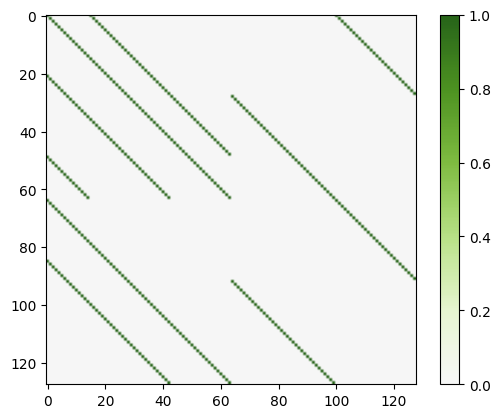

In [22]:
state_matrix_regular = np.load('state_matrix_regular.npz')['state_matrix']
pltimshow(state_matrix_regular)

In [23]:
firststage_basisvects = []

# lo
for i in range(64):
    basisvect = np.zeros(128)
    basisvect[i] = 1
    firststage_basisvects.append(basisvect)

# hi
for i in range(64):
    basisvect = np.zeros(128)
    basisvect[64+i] = 1
    firststage_basisvects.append(basisvect)

# hi ^ lo
for i in range(64):
    basisvect = np.zeros(128)
    basisvect[64+i] = 1
    basisvect[i] = 1
    firststage_basisvects.append(basisvect)

firststage_basisvects = np.array(firststage_basisvects)

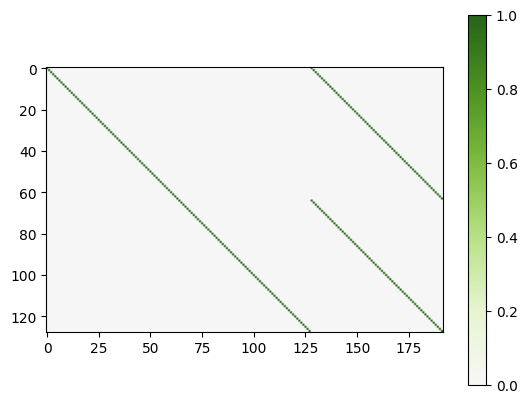

In [24]:
pltimshow(firststage_basisvects.T)

In [25]:
secondstage_basisvects = (state_matrix_regular @ firststage_basisvects.T).T%2

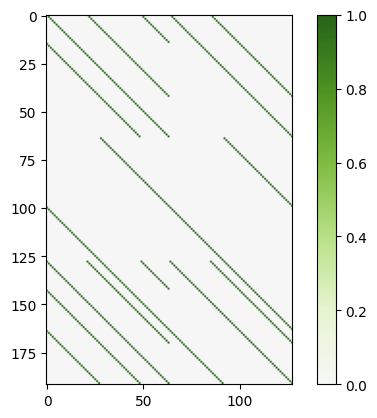

In [26]:
pltimshow(secondstage_basisvects)

In [27]:
bothstage_basisvects = np.vstack([firststage_basisvects,secondstage_basisvects]).astype(int)

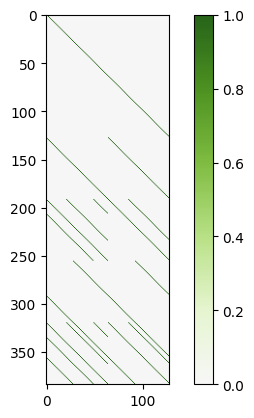

In [28]:
pltimshow(bothstage_basisvects)

In [29]:
bestvect = np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

bestvect.sum() - 64*2

np.float64(42.0)

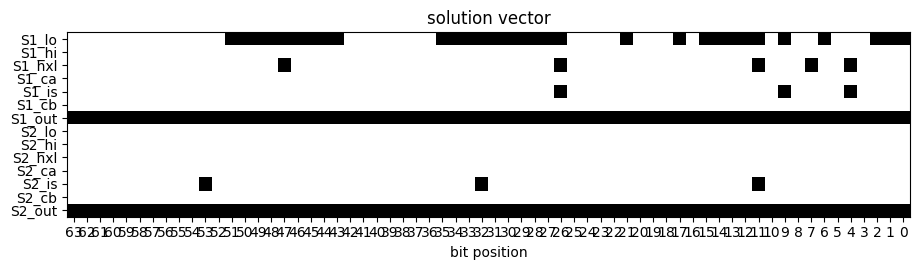

In [30]:
plot_stacked_arrays([
    bestvect.reshape((-1,64)),
],
                   row_labels=blockorder,
                   titles=[
                       'solution vector',
                   ])

In [31]:
filledbest = fill_known_symbols(bestvect)

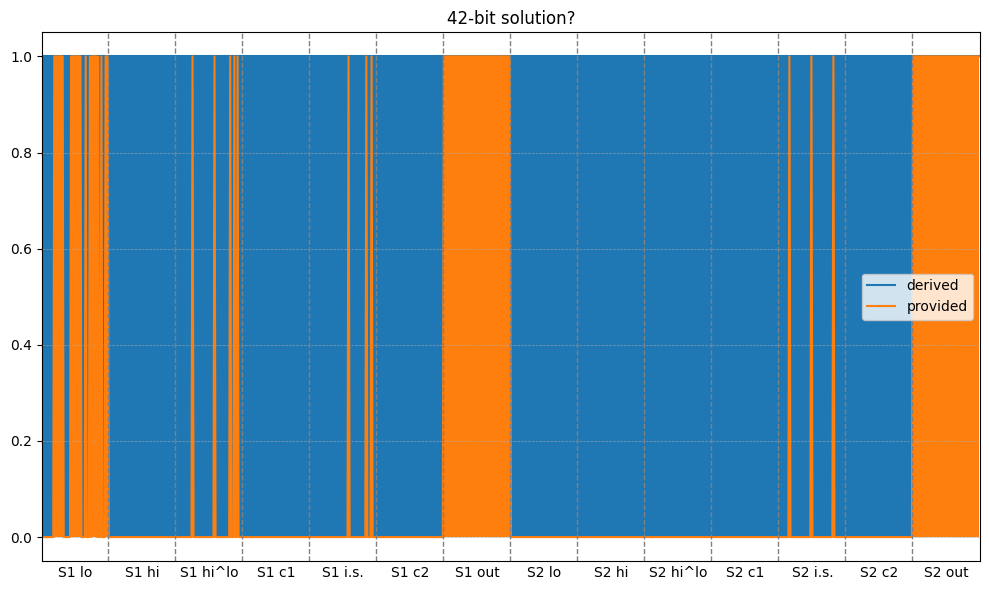

In [32]:
plot_chunked_lines(
    [filledbest,bestvect], 
    ['derived','provided'], 
    ['S1 lo','S1 hi','S1 hi^lo','S1 c1','S1 i.s.','S1 c2','S1 out','S2 lo','S2 hi','S2 hi^lo','S2 c1','S2 i.s.','S2 c2','S2 out'], 
    title=f'{int(bestvect.sum() - 64*2)}-bit solution?'
)

In [33]:
fillhist = fill_known_symbols_history(bestvect)

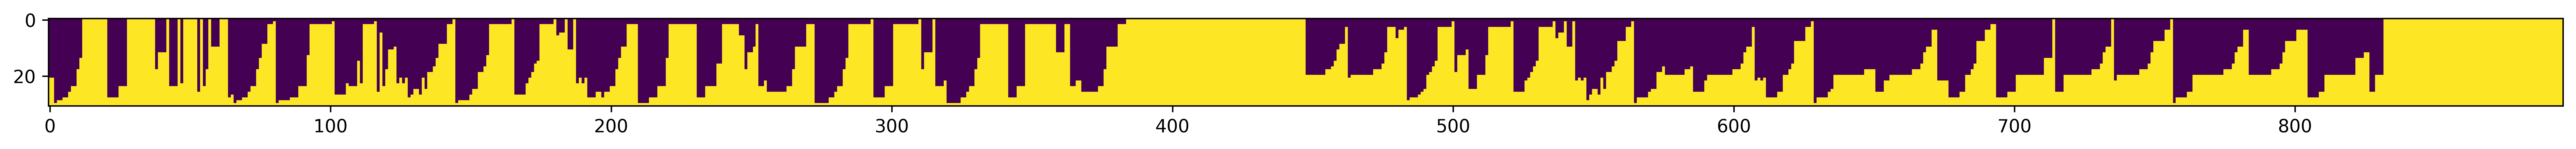

In [34]:
plt.rcParams["figure.figsize"] = (25,5)
plt.gcf().set_dpi(600)
plt.imshow(fillhist)
plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [35]:
vect = bestvect.copy()
operationslist = []

In [36]:
while True:
    known = np.concatenate([vect[:64*3], vect[64*7:64*10]])
    linearvars = all_syms[:64*3] + all_syms[64*7:64*10]
    dep,D,rank = dependency_info(bothstage_basisvects,known)
    for rowidx,row in enumerate(D):
        if not dep[rowidx]:
            continue
        #print(linearvars[rowidx])
        outputname = linearvars[rowidx]
        inputnames = []
        for colidx,col in enumerate(row):
            if not row[colidx]:
                continue
            #print('',linearvars[colidx])
            inputnames.append(linearvars[colidx])
        oper = XOROperation(outputname,inputnames)
        operationslist.append(oper)
        print(oper)

    for op in operationslist:
        vect[all_syms.index(op.output_name)] = 1

    partfillvectnan = vect.astype(float)
    partfillvectnan[partfillvectnan == 0] = np.nan
    foundop = None
    for op in allstate_addops:
        if op.can_apply(all_syms,partfillvectnan):
            print(op)
            foundop = op
            break
    
    if foundop is None:
        break
    
    vect[all_syms.index(foundop.output_name)] = 1
    operationslist.append(foundop)

S1_hi_47 = S1_lo_47 ^ S1_hxl_47
S1_hi_26 = S1_lo_26 ^ S1_hxl_26
S1_hi_11 = S1_lo_11 ^ S1_hxl_11
S2_lo_11 = S1_lo_26 ^ S1_hxl_11
S2_hi_54 = S1_hxl_26
S2_hi_39 = S1_hxl_11
S2_hi_35 = S1_hxl_07
S2_hi_32 = S1_hxl_04
S2_hi_11 = S1_hxl_47
S2_hxl_11 = S1_lo_26 ^ S1_hxl_47 ^ S1_hxl_11
S1_ca_03 = S1_hxl_04 ^ S1_is_04
S1_ca_25 = S1_hxl_26 ^ S1_is_26
S1_ca_26 = carry(S1_ca_25, S1_lo_26, S1_hi_26)
S1_is_47 = S1_lo_00 ^ S1_out_00
S1_ca_46 = S1_hxl_47 ^ S1_is_47
S1_ca_47 = carry(S1_ca_46, S1_lo_47, S1_hi_47)
S1_cb_00 = S1_is_47 & S1_lo_00
S1_is_48 = S1_lo_01 ^ S1_out_01 ^ S1_cb_00
S1_hxl_48 = S1_is_48 ^ S1_ca_47
S1_hi_48 = S1_lo_48 ^ S1_hxl_48
S2_hi_12 = S1_hxl_48
S1_ca_48 = carry(S1_ca_47, S1_lo_48, S1_hi_48)
S1_cb_01 = carry(S1_cb_00, S1_is_48, S1_lo_01)
S1_is_49 = S1_lo_02 ^ S1_out_02 ^ S1_cb_01
S1_hxl_49 = S1_is_49 ^ S1_ca_48
S1_hi_49 = S1_lo_49 ^ S1_hxl_49
S2_hi_13 = S1_hxl_49
S1_ca_49 = carry(S1_ca_48, S1_lo_49, S1_hi_49)
S1_cb_02 = carry(S1_cb_01, S1_is_49, S1_lo_02)
S1_cb_20 = S1_is_04 ^ S1_

In [37]:
assert len(bestvect) - bestvect.sum() == len(operationslist)

In [38]:
lo = random.randint(-2**63, 2**63 - 1)
hi = random.randint(-2**63, 2**63 - 1)
lo &= MASK64
hi &= MASK64

out1A,out2A,nlA,nhA,is1,is2,hxl1,hxl2 = xoroshiro_extended(lo,hi)

In [39]:
truevals = np.zeros(len(all_syms))
truevals[:] = np.nan

blocknum = blockorder.index('S1_out')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(out1A,64)

blocknum = blockorder.index('S2_out')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(out2A,64)

blocknum = blockorder.index('S1_lo')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(lo,64)

blocknum = blockorder.index('S1_hi')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(hi,64)

blocknum = blockorder.index('S2_lo')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(nlA,64)

blocknum = blockorder.index('S2_hi')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(nhA,64)

blocknum = blockorder.index('S1_is')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(is1,64)

blocknum = blockorder.index('S2_is')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(is2,64)

blocknum = blockorder.index('S1_hxl')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(hxl1,64)

blocknum = blockorder.index('S2_hxl')
truevals[64*blocknum:64*(blocknum+1)] = int_to_bin_list(hxl2,64)

In [40]:
guessed_syms = [all_syms[i] for i in np.flatnonzero(bestvect) if 'out' not in all_syms[i]]
len(guessed_syms)

42

In [41]:
provided_syms = [all_syms[i] for i in np.flatnonzero(bestvect)]

In [42]:
datawithguesses = np.empty(bestvect.shape)
datawithguesses[:] = np.nan

In [43]:
for sym,val in zip(all_syms,truevals):
    if sym in provided_syms:
        datawithguesses[all_syms.index(sym)] = val

In [44]:
assert np.isnan(datawithguesses).sum() == len(operationslist)

In [45]:
cracked = datawithguesses.copy()

In [46]:
for opidx,op in enumerate(operationslist):
    assert op.can_apply(all_syms,cracked), (opidx,str(op))
    cracked = op.apply(all_syms,cracked)

In [47]:
assert np.nan_to_num(datawithguesses-truevals).sum() == 0

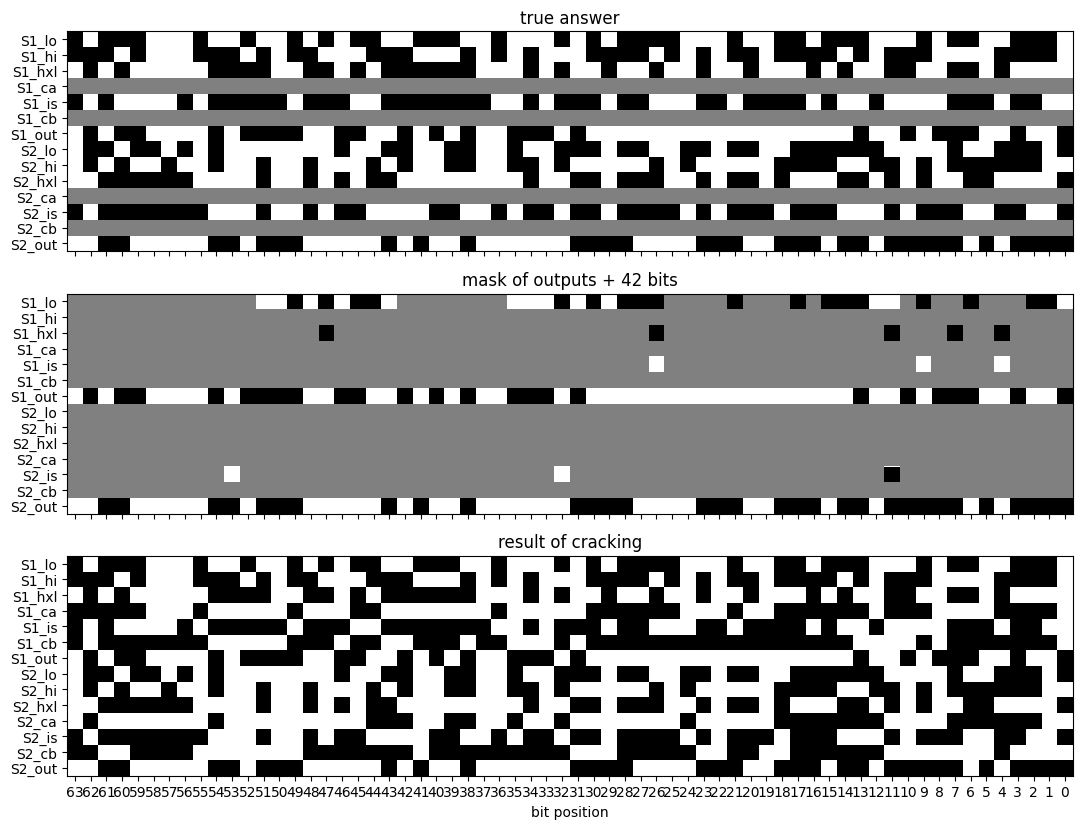

In [48]:
plot_stacked_arrays([
    truevals.reshape((-1,64)),
    datawithguesses.reshape((-1,64)),
    cracked.reshape((-1,64)),
],
                   row_labels=blockorder,
                   titles=[
                       'true answer',
                       f'mask of outputs + {int(bestvect.sum() - 64*2)} bits',
                       'result of cracking',
                   ])